In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from trad_cs_recv_algos import *
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
from mmf_speckle import *
from __init__ import *

In [3]:
dtype=torch.float64
device="cuda"

In [4]:
N = 128*128

In [5]:
W = dct_matrix(N,dtype=dtype,device=device)
WT = torch.inverse(W)

In [6]:
tau=.35
stopCri = 4
tolA = 1.e-3
tolD = 0.0001

In [7]:
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
x_u_list = []
for name in names:
    x_u = get_gi_image(0,device, dtype) if name=="GI" else get_t_image(name,device, dtype)
    x_u_list.append(x_u)

In [8]:
tower_images = np.array(h5py.File("./timg/towers.h5")["Imgs"])
PM_images = [
    get_gi_image(0, device, dtype).reshape((-1,1)),  # PM1 
    torch.tensor(tower_images[0,0,:,:],device=device,dtype=dtype).reshape((-1,1)), # PM2
    get_pre_measure_img(device, dtype).reshape((-1,1))   # PM3
]

## Exp0

In [13]:
algos = ["algo1","algo2"]
PMS = ["PM1","PM2","PM3"]
root="./results/exp0"

In [14]:
recv_res=[]
for algo in algos:
    recv_algo=[]
    for j in range(len(PMS)):
        PM = PMS[j]
        f = h5py.File("{}/{}/{}.h5".format(root,algo,PM))
        recv_name = "A_recv_45" if (algo=="algo2" and j==0) else "A_recv"
        A =  torch.tensor(np.array(f[recv_name]),device=device,dtype=dtype) 
        y = torch.tensor(np.array(f["y_u"]),device=device,dtype=dtype)
        
        y = y.reshape((-1,1))
        
        error = y.to(torch.float32) - A.to(torch.float32) @ x_u_list[1].reshape((-1,1)).to(torch.float32)
        print(abs(error).mean())
        
        AW = A @ W
        hR = lambda x: AW @ x
        AT = lambda x: AW.T @ x

        [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
            GPSR_Basic(
              y,hR,tau,device,dtype,
                Debias=0,
                AT=AT,
                Initialization=AT(y),
                StopCriterion=stopCri,
                ToleranceA=tolA,
                ToleranceD=tolD,
                Iters=100,
                Verbose=False
            )
        recv_img = (W @ theta)
        print("done")
        recv_algo.append(recv_img)
    recv_res.append(recv_algo)

tensor(0.1017, device='cuda:0')
done
tensor(6.7285e-05, device='cuda:0')
done
tensor(8.6133e-05, device='cuda:0')
done
tensor(209.3626, device='cuda:0')
done
tensor(5.3439, device='cuda:0')
done
tensor(0.1121, device='cuda:0')
done


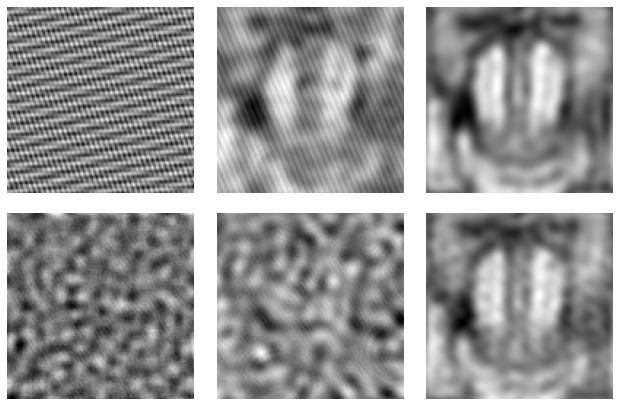

In [16]:
plt.figure(figsize=(3*3,2*3))
for i in range(2):
    for j in range(3):   
        plt.subplot(2,3,j+1+i*3)
        recv_img = recv_res[i][j]
        plt.imshow(recv_img.cpu().numpy().reshape((128,128)),cmap="gray")
        plt.axis("off")
plt.tight_layout(pad=2)
# plt.show()
plt.savefig("{}/recv_res.jpg".format(root))

## Exp1

In [17]:
algos = ["algo1","algo2"]
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
root = "./results/exp1"

In [23]:
recv_list =[]
error_list = []
decay_k_list = []

for algo in algos:
    recv_algo_list=[]
    error_algo_list = []
    decay_k_algo_list = []
    for j in range(7):
        name = names[j]
        f = h5py.File("{}/{}/{}.h5".format(root,algo,name))
        A = torch.tensor(np.array(f["A_recv"]),device=device,dtype=dtype)
        y = torch.tensor(np.array(f["y_u"]),device=device,dtype=dtype)

        y = y.reshape((-1,1))

        error = y.to(torch.float32) - A.to(torch.float32) @ x_u_list[j].reshape((-1,1)).to(torch.float32)
        e = abs(error).mean()
        error_algo_list.append(e)
        print(e)
        
        decay_k_algo_list.append(f["decay_k"])

        AW = A @ W
        hR = lambda x: AW @ x
        AT = lambda x: AW.T @ x

        [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
            GPSR_Basic(
              y,hR,tau,device,dtype,
                Debias=0,
                AT=AT,
                Initialization=AT(y),
                StopCriterion=stopCri,
                ToleranceA=tolA,
                ToleranceD=tolD,
                Iters=100,
                Verbose=False
            )
        recv_img = (W @ theta)
        print("done")
        recv_algo_list.append(recv_img)
    recv_list.append(recv_algo_list)
    error_list.append(error_algo_list)
    decay_k_list.append(decay_k_algo_list)    

tensor(5.6201e-05, device='cuda:0')
done
tensor(8.6133e-05, device='cuda:0')
done
tensor(6.9336e-05, device='cuda:0')
done
tensor(7.2852e-05, device='cuda:0')
done
tensor(7.0312e-05, device='cuda:0')
done
tensor(7.2559e-05, device='cuda:0')
done
tensor(7.3340e-05, device='cuda:0')
done
tensor(0.1006, device='cuda:0')
done
tensor(0.1121, device='cuda:0')
done
tensor(0.1527, device='cuda:0')
done
tensor(0.1587, device='cuda:0')
done
tensor(0.1521, device='cuda:0')
done
tensor(0.2313, device='cuda:0')
done
tensor(0.1608, device='cuda:0')
done


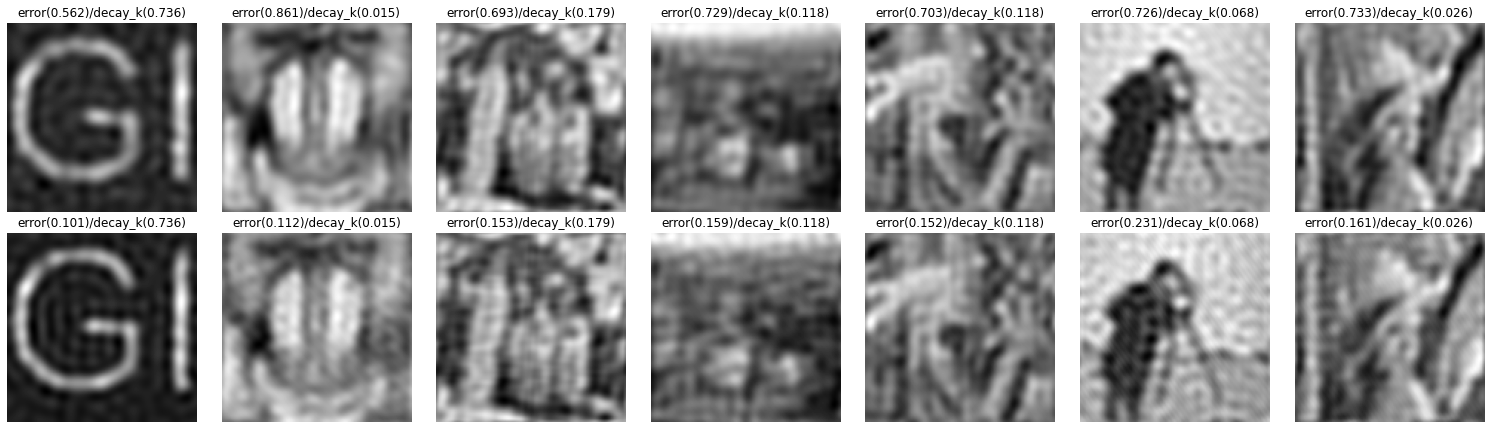

In [43]:
fig=plt.figure(figsize=(7*3,2*3))
for i in range(2):
    for j in range(7):   
        plt.subplot(2,7,j+1+i*7)
        recv_img = recv_list[i][j]
        e = error_list[i][j].item()
        decay_k = abs(np.array(decay_k_list[i][j])[0][0])
        plt.imshow(recv_img.cpu().numpy().reshape((128,128)),cmap="gray")
        if i==0:
            e*=1e4 
            e=round(e,3)
            plt.title("error({})/decay_k({})".format(e, round(decay_k,3)))
        else:
            e=round(e,3)
            plt.title("error({})/decay_k({})".format(e, round(decay_k,3)))
        plt.axis("off")
plt.tight_layout(pad=1)
# plt.show()
plt.savefig("{}/recv_res.jpg".format(root))

## Exp2

In [9]:
root = "./results/exp2-x"
noise = [0,0.5,1,1.5,2,5]
name_idxs=[0,1,2,3,4,5,6]

In [10]:
recv_nosie_list_algo1 =[]
error_nosie_list_algo1 = []
for n in noise:
    recv_n_list=[]
    error_n_list=[]
    for j in name_idxs:
        name = names[j]
        f = h5py.File("{}/algo1/{}/{}.h5".format(root,n,name))
        A = torch.tensor(np.array(f["A_recv"]),device=device,dtype=dtype)
        y = torch.tensor(np.array(f["y_u"]),device=device,dtype=dtype)

        y = y.reshape((-1,1))
        
        error = y.to(torch.float32) - A.to(torch.float32) @ x_u_list[j].reshape((-1,1)).to(torch.float32)
        e = abs(error).mean()
        error_n_list.append(e)
        print(e)
        
        AW = A @ W
        hR = lambda x: AW @ x
        AT = lambda x: AW.T @ x

        [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
            GPSR_Basic(
              y,hR,tau,device,dtype,
                Debias=0,
                AT=AT,
                Initialization=AT(y),
                StopCriterion=stopCri,
                ToleranceA=tolA,
                ToleranceD=tolD,
                Iters=100,
                Verbose=False
            )
        recv_img = (W @ theta)
        print("done")
        recv_n_list.append(recv_img)
    recv_nosie_list_algo1.append(recv_n_list)
    error_nosie_list_algo1.append(error_n_list)

tensor(5.4541e-05, device='cuda:0')
done
tensor(8.5937e-05, device='cuda:0')
done
tensor(6.8945e-05, device='cuda:0')
done
tensor(7.2559e-05, device='cuda:0')
done
tensor(7.0020e-05, device='cuda:0')
done
tensor(7.2559e-05, device='cuda:0')
done
tensor(7.3340e-05, device='cuda:0')
done
tensor(0.1568, device='cuda:0')
done
tensor(0.4206, device='cuda:0')
done
tensor(0.3328, device='cuda:0')
done
tensor(0.3597, device='cuda:0')
done
tensor(0.3727, device='cuda:0')
done
tensor(0.3711, device='cuda:0')
done
tensor(0.3942, device='cuda:0')
done
tensor(0.3089, device='cuda:0')
done
tensor(0.8465, device='cuda:0')
done
tensor(0.6744, device='cuda:0')
done
tensor(0.7191, device='cuda:0')
done
tensor(0.7259, device='cuda:0')
done
tensor(0.7568, device='cuda:0')
done
tensor(0.7893, device='cuda:0')
done
tensor(0.4645, device='cuda:0')
done
tensor(1.2460, device='cuda:0')
done
tensor(0.9941, device='cuda:0')
done
tensor(1.0975, device='cuda:0')
done
tensor(1.1018, device='cuda:0')
done
tensor(1.1

In [18]:
recv_nosie_list_algo2 =[]
error_nosie_list_algo2 = []
for n in noise:
    recv_n_list=[]
    error_n_list=[]
    for j in name_idxs:
        name = names[j]
        f = h5py.File("{}/algo2/{}/{}.h5".format(root,n,name))
        A = torch.tensor(np.array(f["A_recv"]),device=device,dtype=dtype)
        y = torch.tensor(np.array(f["y_u"]),device=device,dtype=dtype)

        y = y.reshape((-1,1))
        
        error = y.to(torch.float32) - A.to(torch.float32) @ x_u_list[j].reshape((-1,1)).to(torch.float32)
        e = abs(error).mean()
        error_n_list.append(e)
        print(e)
        
        AW = A @ W
        hR = lambda x: AW @ x
        AT = lambda x: AW.T @ x

        [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
            GPSR_Basic(
              y,hR,tau,device,dtype,
                Debias=0,
                AT=AT,
                Initialization=AT(y),
                StopCriterion=stopCri,
                ToleranceA=tolA,
                ToleranceD=tolD,
                Iters=100,
                Verbose=False
            )
        recv_img = (W @ theta)
        print("done")
        recv_n_list.append(recv_img)
    recv_nosie_list_algo2.append(recv_n_list)
    error_nosie_list_algo2.append(error_n_list)

tensor(0.1006, device='cuda:0')
done
tensor(0.1121, device='cuda:0')
done
tensor(0.1527, device='cuda:0')
done
tensor(0.1587, device='cuda:0')
done
tensor(0.1521, device='cuda:0')
done
tensor(0.2313, device='cuda:0')
done
tensor(0.1608, device='cuda:0')
done
tensor(0.4262, device='cuda:0')
done
tensor(0.4169, device='cuda:0')
done
tensor(0.4316, device='cuda:0')
done
tensor(0.4361, device='cuda:0')
done
tensor(0.4528, device='cuda:0')
done
tensor(0.4813, device='cuda:0')
done
tensor(0.4419, device='cuda:0')
done
tensor(0.8219, device='cuda:0')
done
tensor(0.8477, device='cuda:0')
done
tensor(0.8418, device='cuda:0')
done
tensor(0.8259, device='cuda:0')
done
tensor(0.8307, device='cuda:0')
done
tensor(0.8811, device='cuda:0')
done
tensor(0.8418, device='cuda:0')
done
tensor(1.2524, device='cuda:0')
done
tensor(1.2129, device='cuda:0')
done
tensor(1.2125, device='cuda:0')
done
tensor(1.2305, device='cuda:0')
done
tensor(1.2181, device='cuda:0')
done
tensor(1.2460, device='cuda:0')
done
t

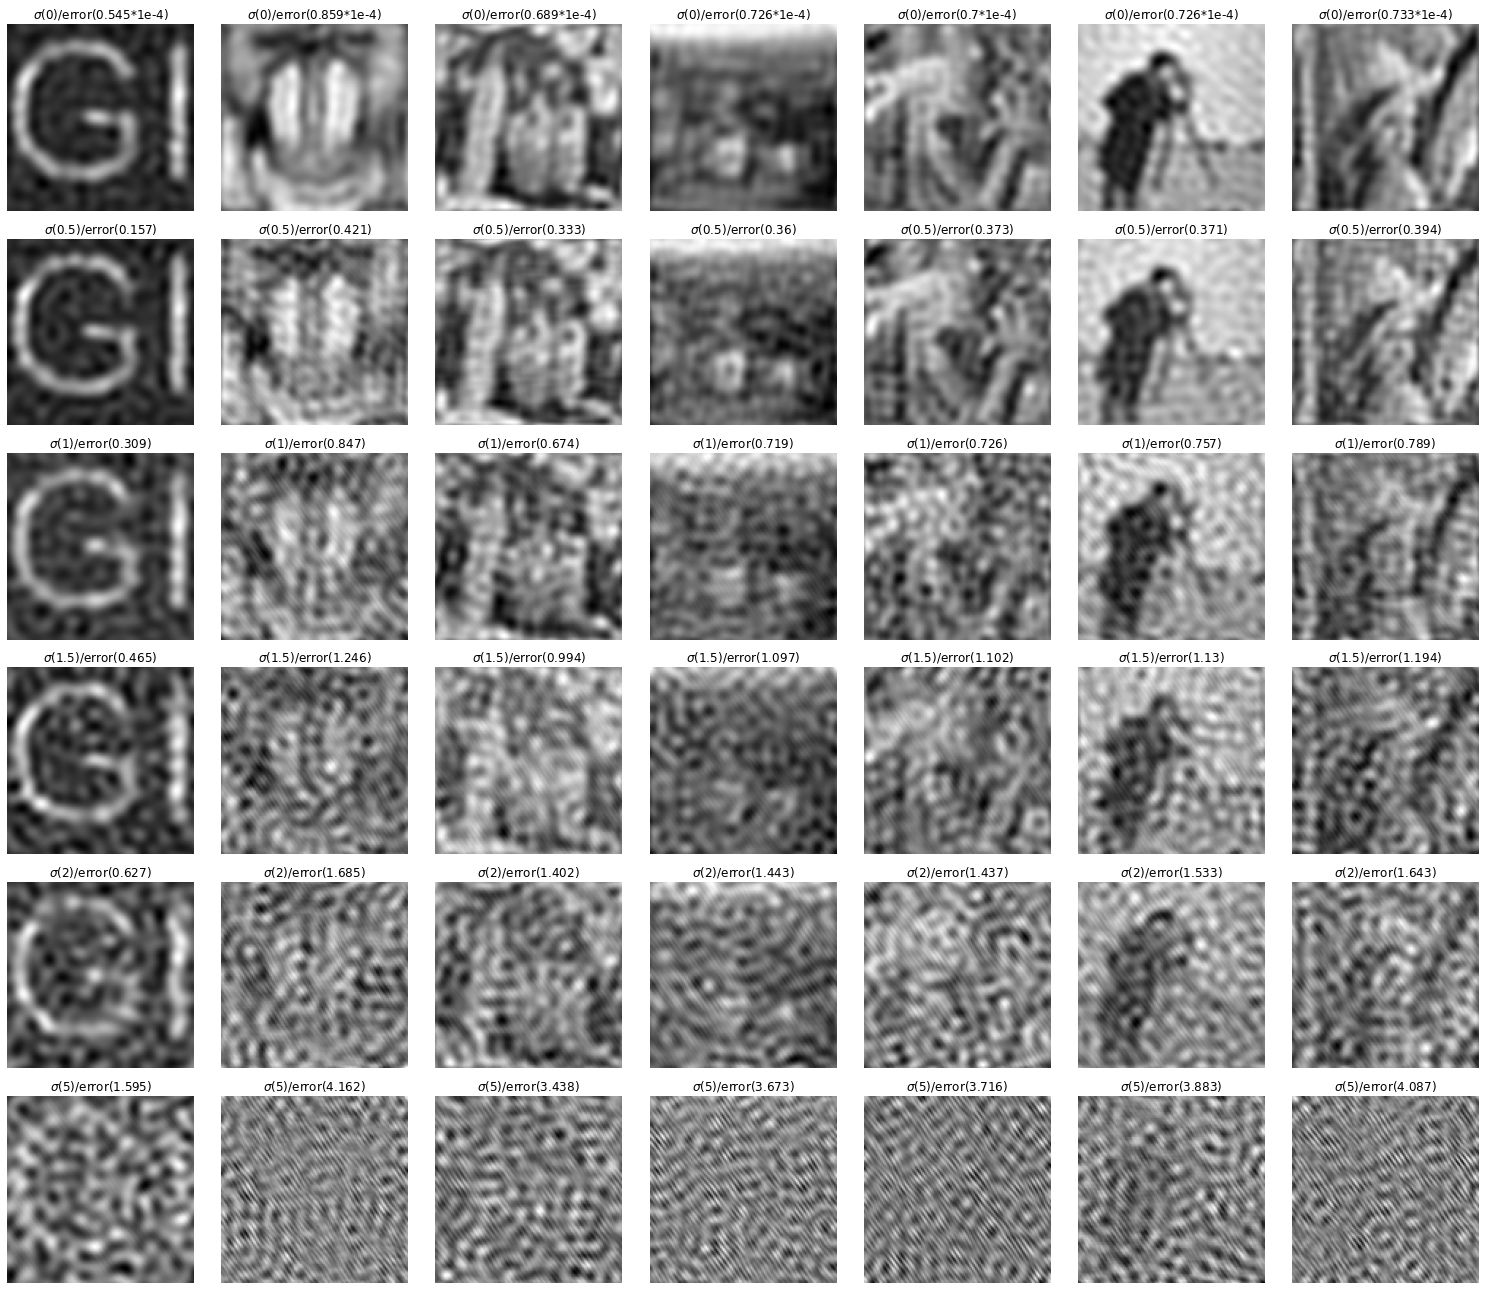

In [17]:
rows=len(noise)
columns=len(name_idxs)
plt.figure(figsize=(columns*3,rows*3))
for i in range(rows):
    for j in range(columns):   
        plt.subplot(rows,columns,j+1+i*columns)
        recv_img = recv_nosie_list_algo1[i][j]
        e = error_nosie_list_algo1[i][j].item()
        plt.imshow(recv_img.cpu().numpy().reshape((128,128)),cmap="gray")
        if i==0:
            plt.title(r"$\sigma$({})/error({}*1e-4)".format(noise[i],round(e*1e4,3)))
        else:
            plt.title(r"$\sigma$({})/error({})".format(noise[i],round(e,3)))
        plt.axis("off")
plt.tight_layout(pad=1)
# plt.show()
plt.savefig("{}/recv_res_algo1-r.jpg".format(root))

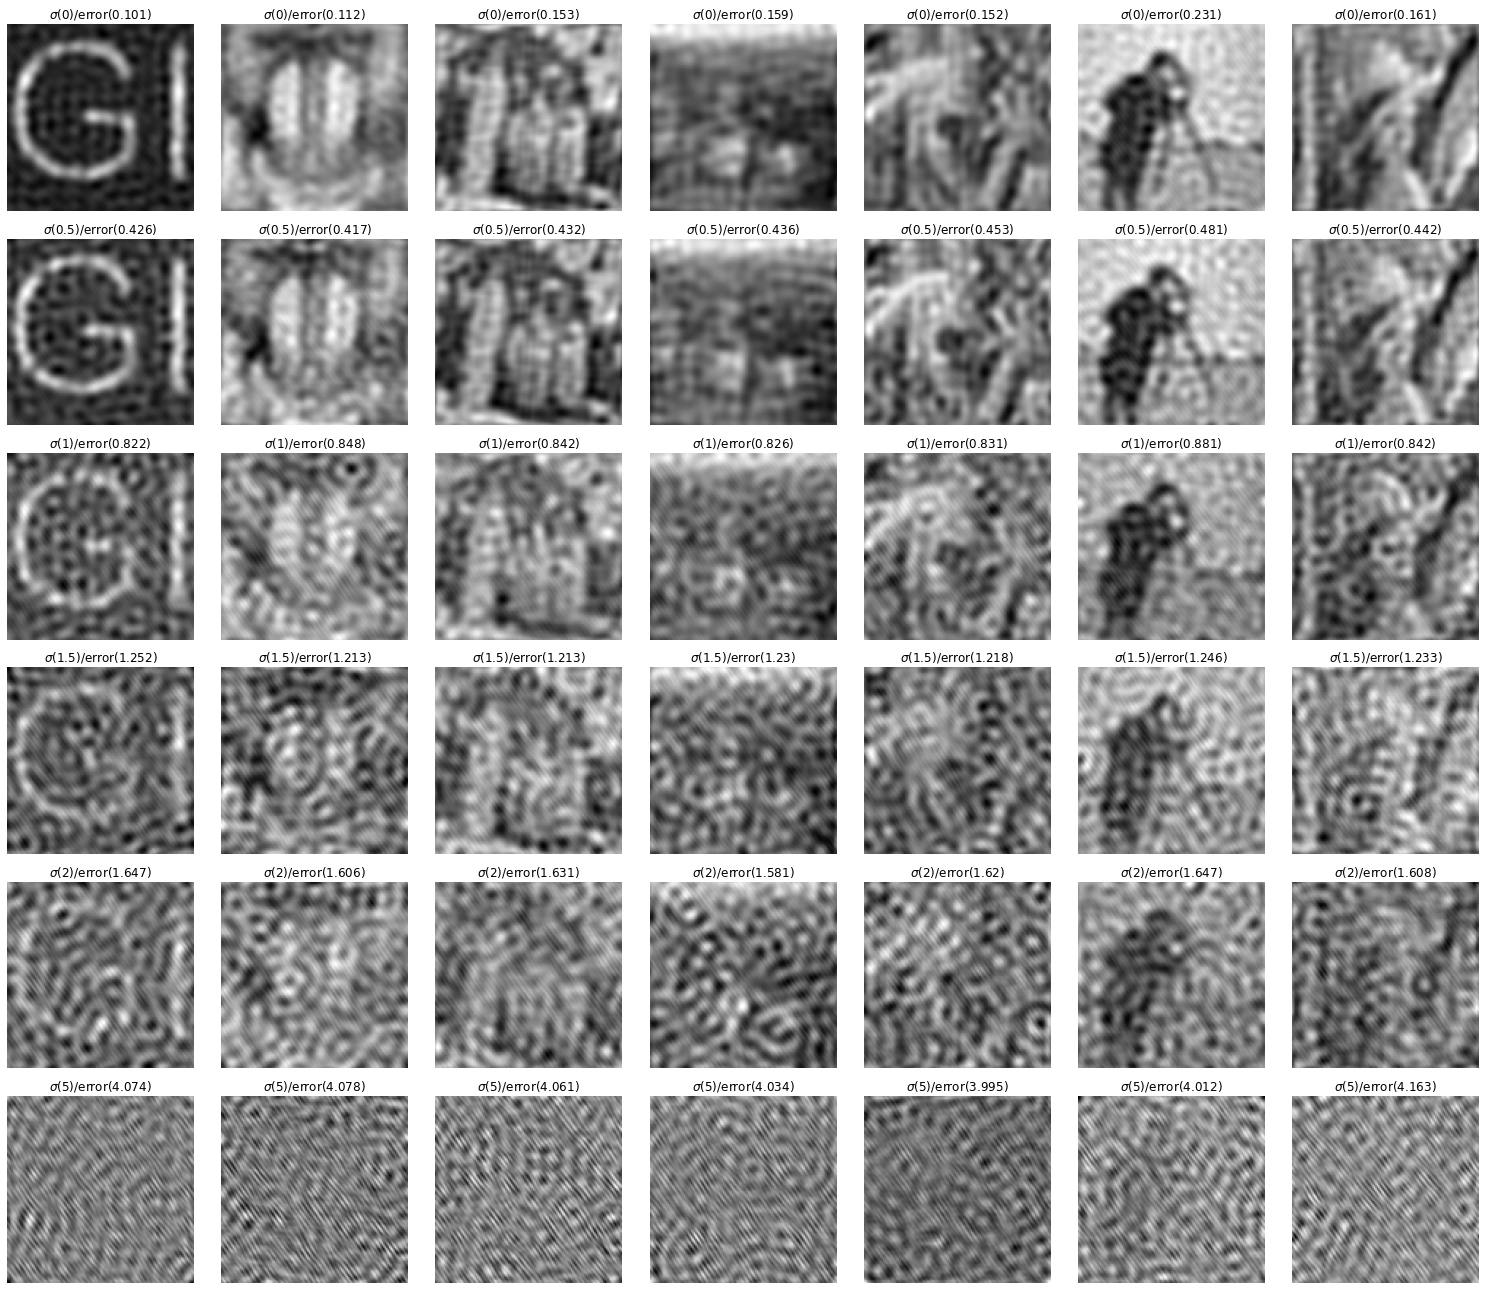

In [20]:
rows=len(noise)
columns=len(name_idxs)
plt.figure(figsize=(columns*3,rows*3))
for i in range(rows):
    for j in range(columns):   
        plt.subplot(rows,columns,j+1+i*columns)
        recv_img = recv_nosie_list_algo2[i][j]
        e = error_nosie_list_algo2[i][j].item()
        plt.imshow(recv_img.cpu().numpy().reshape((128,128)),cmap="gray")
        plt.title(r"$\sigma$({})/error({})".format(noise[i],round(e,3)))
        plt.axis("off")
plt.tight_layout(pad=1)
# plt.show()
plt.savefig("{}/recv_res_algo2-r.jpg".format(root))